In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

In [2]:
import sys
sys.path.append('../')
from networks import *
from images_compose import *

In [3]:
config = TransformConfig()
composed_train = config.composed_train
composed_test = config.composed_test

In [10]:
#transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
#dataset = datasets.CIFAR10(root='mnist_data', download=True, transform=transform)

In [4]:
train_dataset =  datasets.CIFAR10(root='./data', train=True, download=True, transform = composed_train)
validation_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform = composed_test)

# Create train and validation batch for training
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=100)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=100)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.get_device_name(torch.cuda.current_device()))

NVIDIA GeForce RTX 4060 Ti


In [13]:
def train_model(model, train_loader, validation_loader, n_epochs = 100):
    
    # Global variable
    criterion = nn.CrossEntropyLoss()
    learning_rate = 0.1
    optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
    
    N_test = len(validation_dataset)
    accuracy_list = []
    train_loss_list = []
    model = model.to(device)
    train_cost_list = []
    val_cost_list = []
    
    for epoch in range(n_epochs):
        train_COST = 0
        for x,y in train_loader:
            x = x.to(device)
            y = y.to(device)
            model.train()
            optimizer.zero_grad()
            z = model(x)
            loss = criterion(z,y)
            loss.backward()
            optimizer.step()
            train_COST+=loss.item()
            
        train_COST = train_COST/len(train_loader)
        train_cost_list.append(train_COST)
        correct = 0
        
        # Perform the prediction on the validation data
        val_COST = 0
        for x_test, y_test in validation_loader:
            model.eval()
            x_test = x_test.to(device)
            y_test = y_test.to(device)
            z = model(x_test)
            val_loss = criterion(z, y_test)
            _, yhat = torch.max(z.data, 1)
            correct += (yhat==y_test).sum().item()
            val_COST+=val_loss.item()
        
        val_COST = val_COST/ len(validation_loader)
        val_cost_list.append(val_COST)
            
        accuracy = correct / N_test
        accuracy_list.append(accuracy)
        
        print("--> Epoch Number : {}".format(epoch + 1),
            " | Training Loss : {}".format(round(train_COST,4)),
            " | Validation Loss : {}".format(round(val_COST,4)),
              " | Validation Accuracy : {}%".format(round(accuracy * 100, 2)))
        
    return accuracy_list, train_cost_list, val_cost_list

In [14]:
model = NN02()
accuracy_list_normal, train_cost_list, val_cost_list = train_model(model, train_loader, validation_loader)

--> Epoch Number : 1  | Training Loss : 1.6933  | Validation Loss : 1.4779  | Validation Accuracy : 46.99%
--> Epoch Number : 2  | Training Loss : 1.4329  | Validation Loss : 1.3246  | Validation Accuracy : 52.75%
--> Epoch Number : 3  | Training Loss : 1.3402  | Validation Loss : 1.2481  | Validation Accuracy : 55.66%
--> Epoch Number : 4  | Training Loss : 1.2901  | Validation Loss : 1.197  | Validation Accuracy : 57.57%
--> Epoch Number : 5  | Training Loss : 1.2502  | Validation Loss : 1.1685  | Validation Accuracy : 58.29%
--> Epoch Number : 6  | Training Loss : 1.2154  | Validation Loss : 1.1756  | Validation Accuracy : 58.28%
--> Epoch Number : 7  | Training Loss : 1.1884  | Validation Loss : 1.1216  | Validation Accuracy : 60.67%
--> Epoch Number : 8  | Training Loss : 1.1635  | Validation Loss : 1.1074  | Validation Accuracy : 60.8%
--> Epoch Number : 9  | Training Loss : 1.1411  | Validation Loss : 1.0765  | Validation Accuracy : 62.24%
--> Epoch Number : 10  | Training Loss 

In [15]:
def KFold_Model(model, optimizer, k = 5, epochs = 5, dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform = composed_train)):
  
  kf = KFold(n_splits=k, random_state=56, shuffle=True)
  accuracies = []
  torch.manual_seed(56)

  for train_idx, test_idx in kf.split(dataset):
      train_loader = DataLoader(Subset(dataset, train_idx), batch_size=128, shuffle=True)
      test_loader = DataLoader(Subset(dataset, test_idx), batch_size=128, shuffle=False)

      criterion = nn.CrossEntropyLoss()
      model = model.to(device)
      # Training
      for epoch in range(epochs):
          model.train()
          for images, labels in train_loader:
              images, labels = images.to(device), labels.to(device)
              optimizer.zero_grad()
              outputs = model(images)
              loss = criterion(outputs, labels)
              loss.backward()
              optimizer.step()

      # Evaluation
      model.eval()
      correct, total = 0, 0
      with torch.no_grad():
          for images, labels in test_loader:
              images, labels = images.to(device), labels.to(device)
              outputs = model(images)
              _, predicted = torch.max(outputs, 1)
              total += labels.size(0)
              correct += (predicted == labels).sum().item()

      accuracy = 100 * correct / total
      accuracies.append(accuracy)
      print(f'Fold Accuracy: {accuracy}%')

  print(f'Mean Accuracy: {np.mean(accuracies)}%')
  print(f'Standard Deviation: {np.std(accuracies)}%')

Files already downloaded and verified


In [11]:
dataset = datasets.CIFAR10(root='./data', train=True, download=True)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

Files already downloaded and verified


* LR = 0,01
* 5 folds
* 5 epochs
* batch_size=100
* momentum=0.9
* transformer

In [7]:
model = NN05()
KFold_Model(model)

Fold Accuracy: 62.59%
Fold Accuracy: 66.54%
Fold Accuracy: 68.5%
Fold Accuracy: 69.75%
Fold Accuracy: 69.12%
Mean Accuracy: 67.3%
Standard Deviation: 2.589077055631986%


* LR = 0,01
* 5 folds
* 5 epochs
* batch_size=128
* momentum=0.9
* transformer

In [9]:
model = NN05()
KFold_Model(model)

Fold Accuracy: 61.81%
Fold Accuracy: 66.86%
Fold Accuracy: 69.44%
Fold Accuracy: 69.93%
Fold Accuracy: 70.59%
Mean Accuracy: 67.726%
Standard Deviation: 3.217045849844233%


In [16]:
model = NN05()
optimizer = optim.SGD(model.parameters(), lr=0.01)
dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform = composed_train)

KFold_Model(model = model, 
            dataset = dataset,
            optimizer = optimizer,
            k = 5,
            epochs = 10)

Fold Accuracy: 53.71%
Fold Accuracy: 62.11%
Fold Accuracy: 63.75%
Fold Accuracy: 66.99%
Fold Accuracy: 68.04%
Mean Accuracy: 62.92%
Standard Deviation: 5.078354064064459%


In [17]:
model = NN05()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform = composed_train)

KFold_Model(model = model, 
            dataset = dataset,
            optimizer = optimizer,
            k = 5,
            epochs = 10)

Files already downloaded and verified
Fold Accuracy: 64.53%
Fold Accuracy: 68.1%
Fold Accuracy: 70.98%
Fold Accuracy: 72.78%
Fold Accuracy: 72.61%
Mean Accuracy: 69.8%
Standard Deviation: 3.1251175977873222%


In [36]:
model = NN05()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.2)
dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform = composed_train)

KFold_Model(model = model, 
            dataset = dataset,
            optimizer = optimizer,
            k = 5,
            epochs = 10)

Files already downloaded and verified
Fold Accuracy: 55.86%


KeyboardInterrupt: 

In [11]:
model = NN05()
KFold_Model(model)

Fold Accuracy: 68.07%
Fold Accuracy: 70.37%
Fold Accuracy: 72.3%
Fold Accuracy: 72.17%
Fold Accuracy: 73.29%
Mean Accuracy: 71.24000000000001%
Standard Deviation: 1.843735338924763%


VALIDATION

In [32]:
def evaluate_model(model, validation_dataset):
    val_loader = DataLoader(validation_dataset, batch_size=128, shuffle=False)
    model.eval()
    correct, total = 0, 0
    y_true, y_pred = [], []
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            y_true.extend(labels.cpu().numpy())  # Mover a CPU antes de convertir a numpy
            y_pred.extend(predicted.cpu().numpy())  # Mover a CPU antes de convertir a numpy
    
    val_accuracy = 100 * correct / total
    print(f'Validation Accuracy: {val_accuracy}%')
    
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()


Files already downloaded and verified
Validation Accuracy: 76.19%


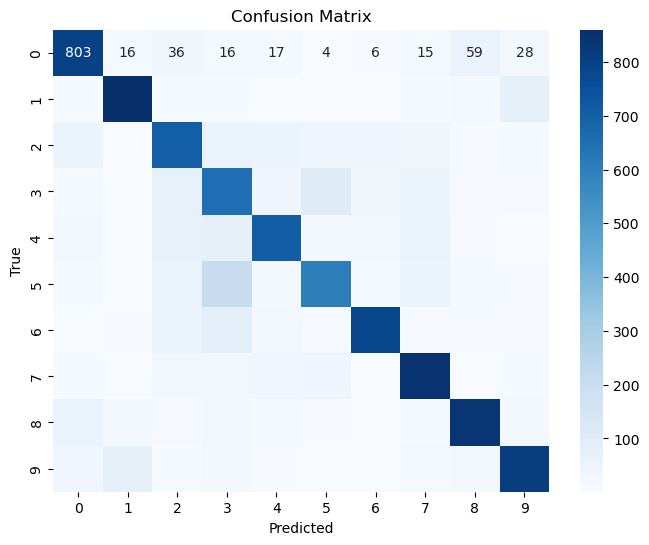

In [33]:
validation_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform = composed_test)

evaluate_model(model, validation_dataset)